In [14]:
import pandas as pd
import os
import sys

def aggregate_data_part(data_part_name: str) -> pd.DataFrame:

    notebook_dir = os.getcwd()
    project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
    base_path = os.path.join(project_root, 'data', 'SDHAR')

    print(f"Starting data aggregation for part: '{PART_TO_AGGREGATE}'")
    print(f"Detected data directory: '{base_path}'\n")

    all_dataframes = []

    if not os.path.isdir(base_path):
        print(f"Error: Base directory not found at '{base_path}'")
        print("Please ensure your directory structure is correct: project_root/data/SDHAR/")
        return pd.DataFrame()

    day_folders = sorted([d for d in os.listdir(base_path) if d.startswith('DAY_') and os.path.isdir(os.path.join(base_path, d))])

    if not day_folders:
        print(f"Warning: No 'DAY_X' folders found in '{base_path}'")
        return pd.DataFrame()

    print(f"Found {len(day_folders)} day folders. Processing...")

    for day_folder in day_folders:
        part_path = os.path.join(base_path, day_folder, day_folder, data_part_name)

        if not os.path.isdir(part_path):
            continue

        csv_files = [f for f in os.listdir(part_path) if f.lower().endswith('.csv')]

        for csv_file in csv_files:
            file_path = os.path.join(part_path, csv_file)
            try:
                temp_df = pd.read_csv(file_path)
                temp_df['source_day'] = day_folder
                temp_df['source_file'] = csv_file
                all_dataframes.append(temp_df)
            except Exception as e:
                print(f"Could not read or process file '{file_path}' because {e}")

    if not all_dataframes:
        print(f"No CSV files found for '{data_part_name}'.")
        return pd.DataFrame()

    # Concatenate all dataframes into one
    final_df = pd.concat(all_dataframes, ignore_index=True)
    return final_df

In [17]:
PART_TO_AGGREGATE = 'Activities'
activities_df = aggregate_data_part(PART_TO_AGGREGATE)

print(f"Shape of the final DataFrame: {activities_df.shape} (rows, columns)")
print("\nActivities Info:")
activities_df.info()

Starting data aggregation for part: 'Activities'
Detected data directory: 'C:\Users\jesse\OneDrive - University of Georgia\25-26\Fall 2025\Data Mining\SDHAR\SDHAR-Dataset-Project\data\SDHAR'

Found 62 day folders. Processing...
Shape of the final DataFrame: (8854, 7) (rows, columns)

Activities Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8854 entries, 0 to 8853
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   time                       8854 non-null   object
 1   activity_predicted_user_1  3664 non-null   object
 2   source_day                 8854 non-null   object
 3   source_file                8854 non-null   object
 4   activity_predicted_user_2  2713 non-null   object
 5   activity_user_1            1545 non-null   object
 6   activity_user_2            932 non-null    object
dtypes: object(7)
memory usage: 484.3+ KB


### How do the daily routines of User 1 and User 2 differ? What is the frequency distribution across the 18 activities for each user?

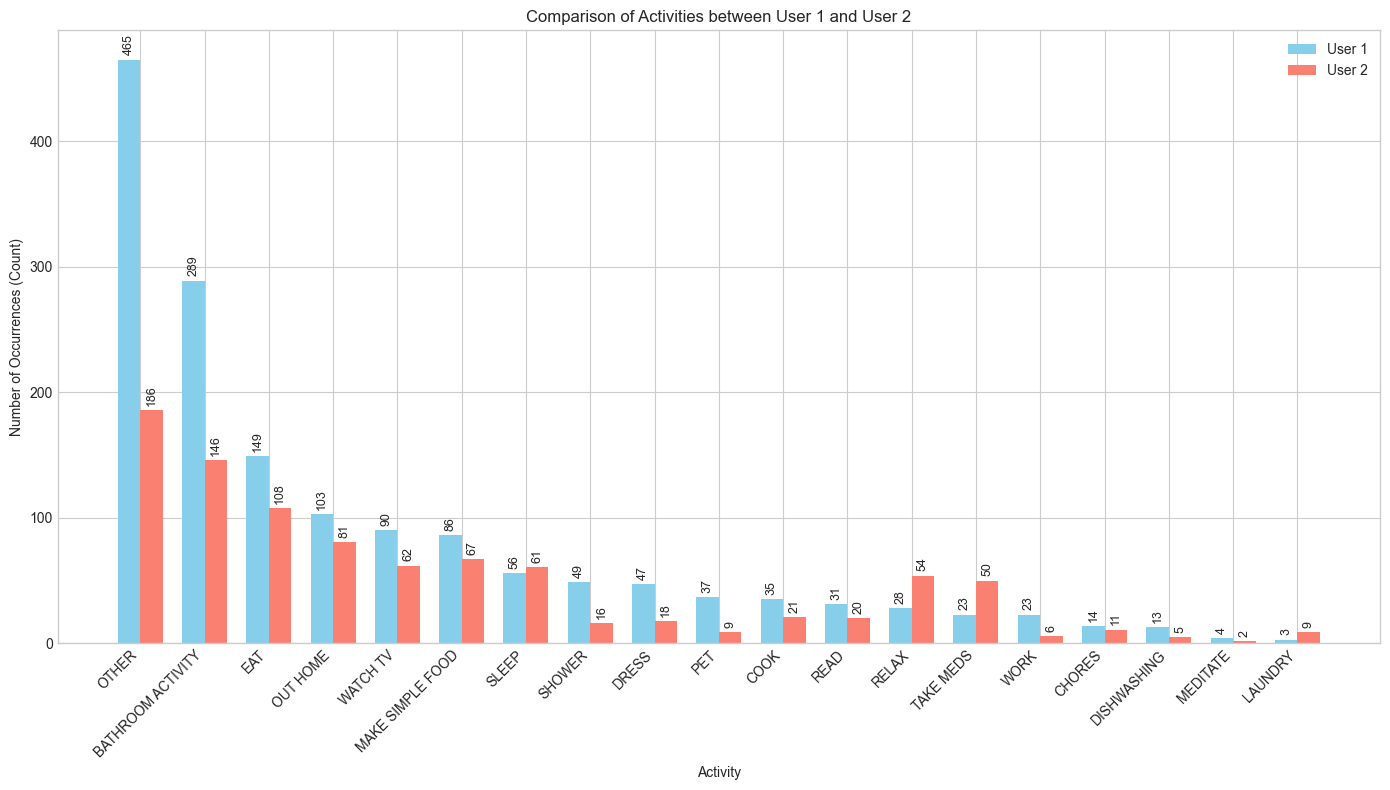

In [21]:
import matplotlib.pyplot as plt
import numpy as np

user1_counts = activities_df['activity_user_1'].value_counts()
user2_counts = activities_df['activity_user_2'].value_counts()

comparison_df = pd.concat([user1_counts, user2_counts], axis=1, keys=['User 1', 'User 2'])

comparison_df = comparison_df.fillna(0).astype(int)
comparison_df = comparison_df.sort_values(by='User 1', ascending=False)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(comparison_df.index))
width = 0.35
rects1 = ax.bar(x - width/2, comparison_df['User 1'], width, label='User 1', color='skyblue')
rects2 = ax.bar(x + width/2, comparison_df['User 2'], width, label='User 2', color='salmon')

ax.set_ylabel('Number of Occurrences (Count)')
ax.set_xlabel('Activity')
ax.set_title('Comparison of Activities between User 1 and User 2')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')
ax.legend()
ax.bar_label(rects1, padding=3, rotation=90, fontsize=9)
ax.bar_label(rects2, padding=3, rotation=90, fontsize=9)

fig.tight_layout()
plt.show()

### What are the most common sequences of activities for each user?  

In [23]:
def find_activity_transitions(activity_series: pd.Series):
    transitions_df = pd.DataFrame({
        'previous': activity_series,
        'current': activity_series.shift(-1)
    })

    transitions_df.dropna(inplace=True)
    activity_changes = transitions_df[transitions_df['previous'] != transitions_df['current']]
    transition_counts = activity_changes.groupby(['previous', 'current']).size()
    return transition_counts.sort_values(ascending=False)



# Find the top 15 transitions for each User
user1_transitions = find_activity_transitions(activities_df['activity_user_1'])
user2_transitions = find_activity_transitions(activities_df['activity_user_2'])

print("--- Top 15 Consecutive Activities for User 1 ---")
print(user1_transitions.head(15))

print("\n" + "="*50 + "\n")

print("--- Top 15 Consecutive Activities for User 2 ---")
print(user2_transitions.head(15))

--- Top 15 Consecutive Activities for User 1 ---
previous           current          
BATHROOM ACTIVITY  OTHER                196
OUT HOME           OTHER                 95
OTHER              OUT HOME              86
MAKE SIMPLE FOOD   EAT                   85
OTHER              BATHROOM ACTIVITY     84
EAT                BATHROOM ACTIVITY     67
OTHER              MAKE SIMPLE FOOD      62
SHOWER             OTHER                 48
BATHROOM ACTIVITY  SHOWER                45
OTHER              WATCH TV              38
WATCH TV           OTHER                 34
OTHER              DRESS                 33
COOK               EAT                   31
READ               SLEEP                 30
EAT                WATCH TV              30
dtype: int64


--- Top 15 Consecutive Activities for User 2 ---
previous           current          
OTHER              BATHROOM ACTIVITY    55
TAKE MEDS          OTHER                49
MAKE SIMPLE FOOD   EAT                  47
BATHROOM ACTIVITY  OTHER

### How often does each activity get done every week?

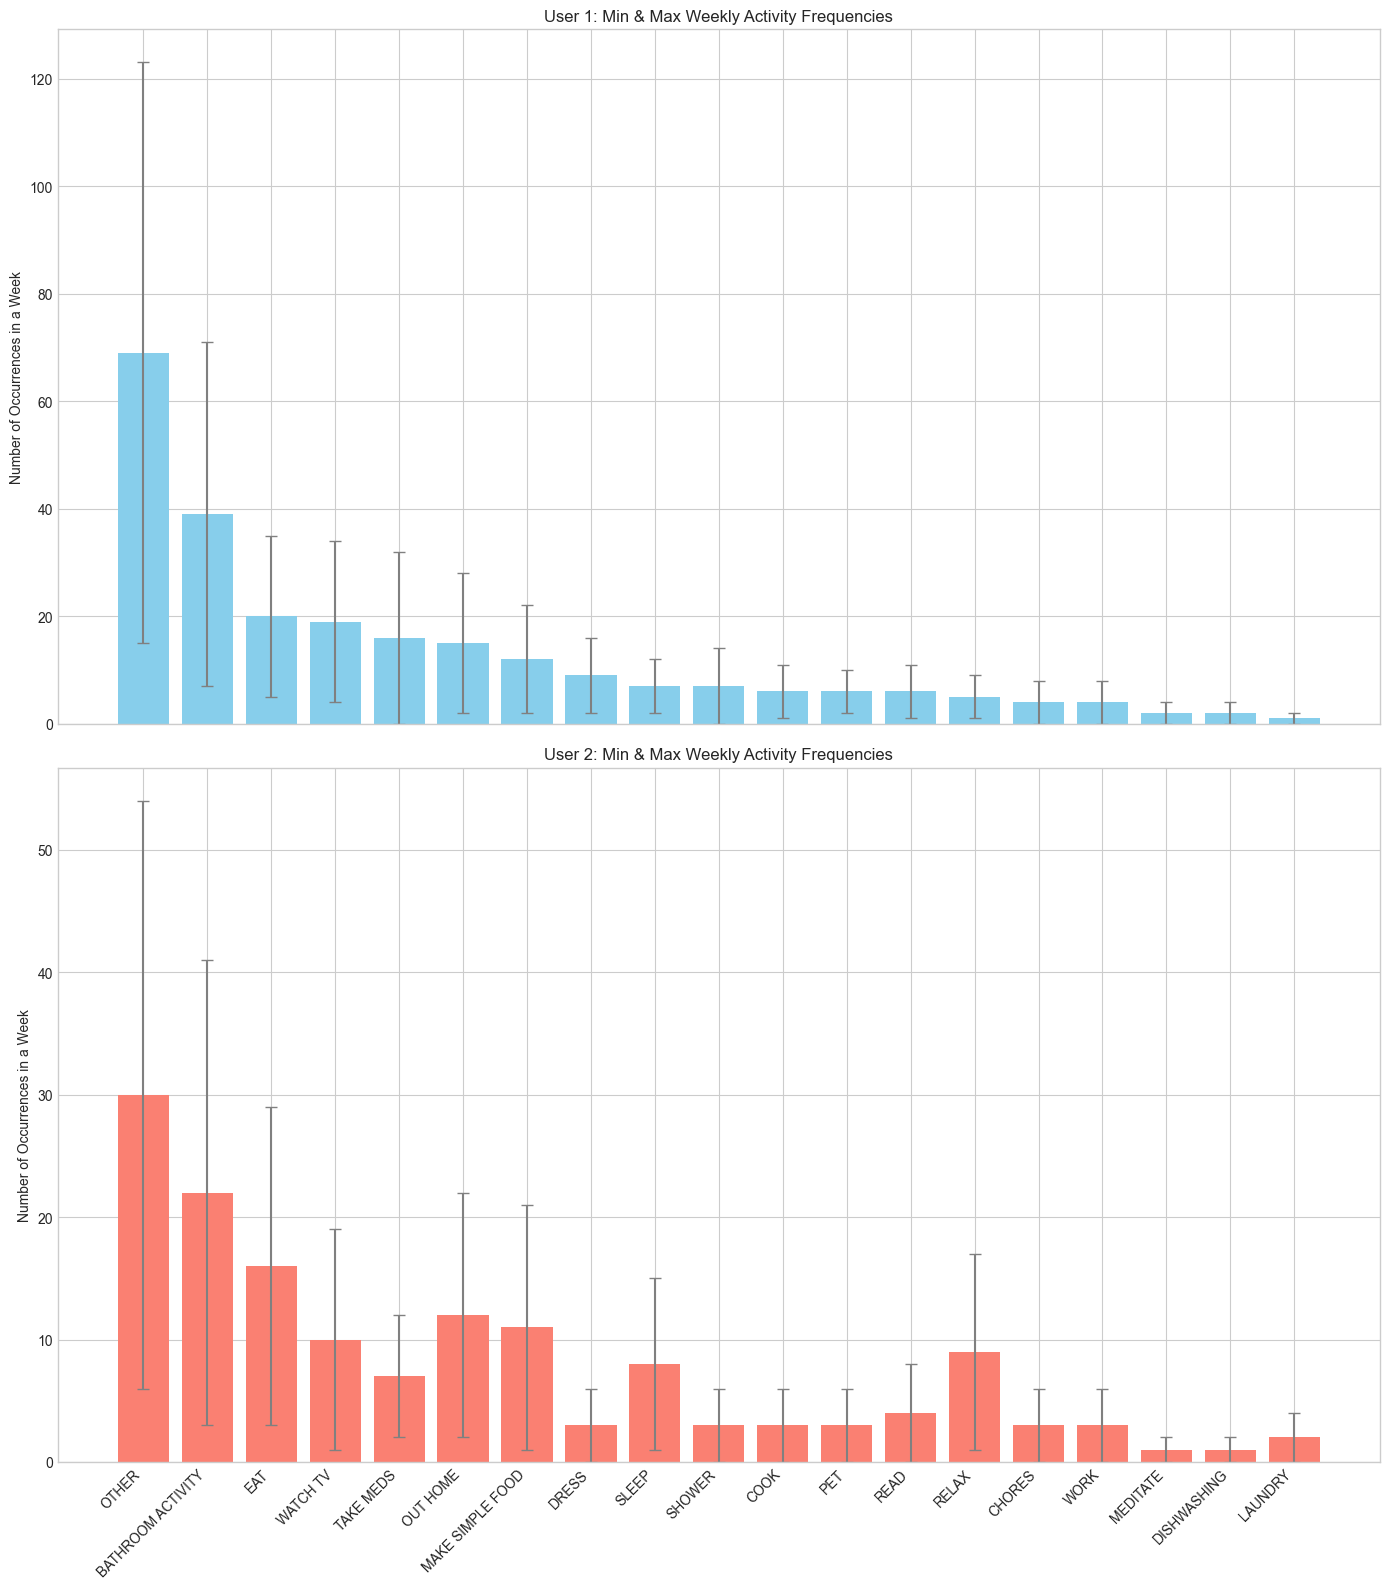

In [26]:
def get_weekly_frequency_range_from_time(df, user_activity_col):
    temp_df = df[[user_activity_col, 'time']].copy()

    # Convert the 'time' column to datetime objects
    #    errors='coerce' will turn any unparseable dates into NaT (Not a Time)
    temp_df['datetime'] = pd.to_datetime(temp_df['time'], errors='coerce')

    temp_df.dropna(subset=['datetime'], inplace=True)
    temp_df['week'] = temp_df['datetime'].dt.isocalendar().week

    weekly_counts = temp_df.groupby(['week', user_activity_col]).size().unstack(fill_value=0)

    all_activities = df[user_activity_col].dropna().unique()
    weekly_counts = weekly_counts.reindex(columns=all_activities, fill_value=0)

    freq_range = pd.DataFrame({
        'min': weekly_counts.min(),
        'max': weekly_counts.max()
    })

    return freq_range.sort_values(by='max', ascending=False)

user1_freq_range = get_weekly_frequency_range_from_time(activities_df, 'activity_user_1')
user2_freq_range = get_weekly_frequency_range_from_time(activities_df, 'activity_user_2')

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 16), sharex=True)

y_error1 = user1_freq_range['max'] - user1_freq_range['min']
ax1.bar(user1_freq_range.index, user1_freq_range['max'],
        yerr=y_error1, capsize=4, color='skyblue', ecolor='gray')
ax1.set_title('User 1: Min & Max Weekly Activity Frequencies')
ax1.set_ylabel('Number of Occurrences in a Week')
ax1.tick_params(axis='x', rotation=45)

y_error2 = user2_freq_range['max'] - user2_freq_range['min']
ax2.bar(user2_freq_range.index, user2_freq_range['max'],
        yerr=y_error2, capsize=4, color='salmon', ecolor='gray')
ax2.set_title('User 2: Min & Max Weekly Activity Frequencies')
ax2.set_ylabel('Number of Occurrences in a Week')
plt.xticks(rotation=45, ha='right')

fig.tight_layout()
plt.show()